Using device: cuda:0
SIREN compression ratio: 2.04:1
SIREN parameter count: 385
Model parameters: 1,190,929
Loading MNIST data...
Training samples: 60000
Test samples: 10000
Batch size: 64
Starting SIREN autoencoder training...
Epoch   0 | Train Loss: 0.231135 | Test Loss: 0.230758 | Time: 6.87s
Epoch   1 | Train Loss: 0.230177 | Test Loss: 0.229776 | Time: 6.83s
Epoch   2 | Train Loss: 0.229096 | Test Loss: 0.228525 | Time: 6.87s
Epoch   3 | Train Loss: 0.227310 | Test Loss: 0.225712 | Time: 6.74s
Epoch   4 | Train Loss: 0.217593 | Test Loss: 0.192100 | Time: 6.82s
Epoch   5 | Train Loss: 0.102762 | Test Loss: 0.071137 | Time: 6.73s
Epoch   6 | Train Loss: 0.069719 | Test Loss: 0.069235 | Time: 6.72s
Epoch   7 | Train Loss: 0.068674 | Test Loss: 0.068400 | Time: 6.78s
Epoch   8 | Train Loss: 0.067825 | Test Loss: 0.067602 | Time: 6.71s
Epoch   9 | Train Loss: 0.067147 | Test Loss: 0.067131 | Time: 6.73s
Epoch  10 | Train Loss: 0.066701 | Test Loss: 0.066715 | Time: 6.79s
Epoch  11 | T

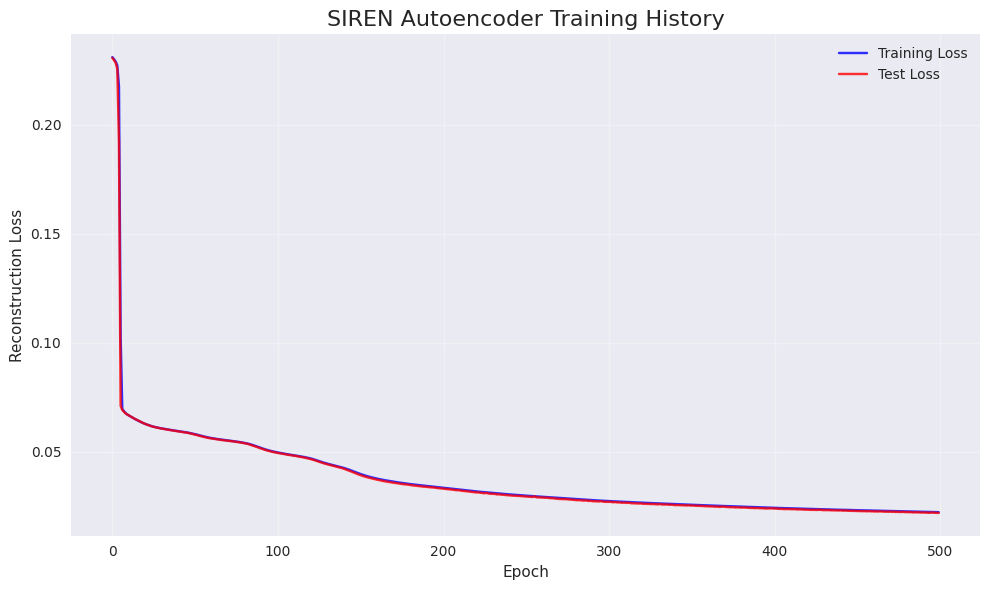

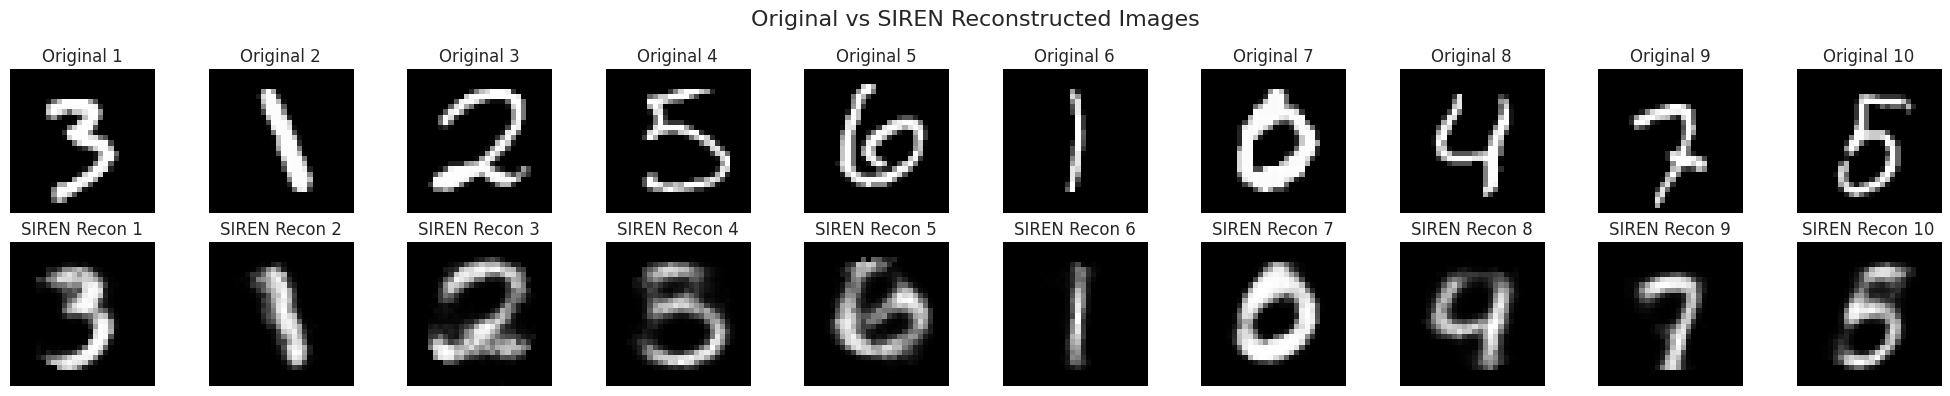

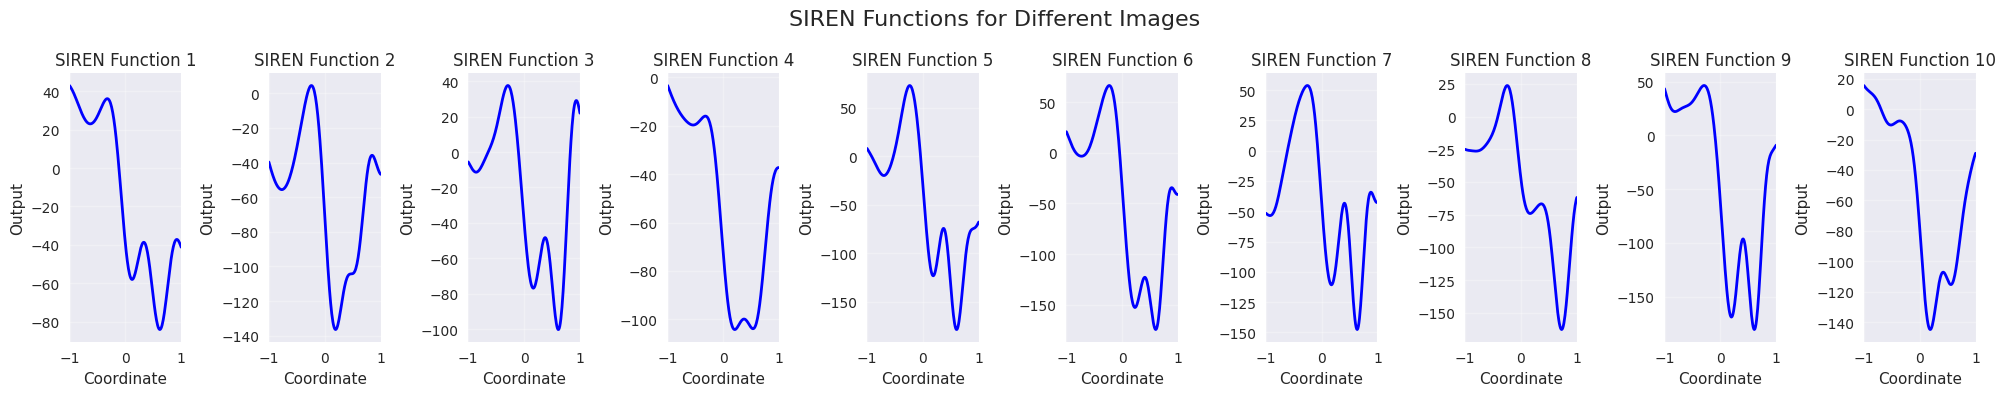

SIREN AUTOENCODER COMPRESSION ANALYSIS
Latent Dimension: 64
SIREN Parameters: 385
SIREN Hidden Dims: [128]
Omega_0: 5.0
Compression Ratio: 2.04:1
Original Size: 784 pixels
Compressed Size: 385 SIREN params
Mean MSE: 0.022452 ± 0.011404
Mean PSNR: 17.20 dB
All visualizations complete!

=== Analysis for digit 4 ===


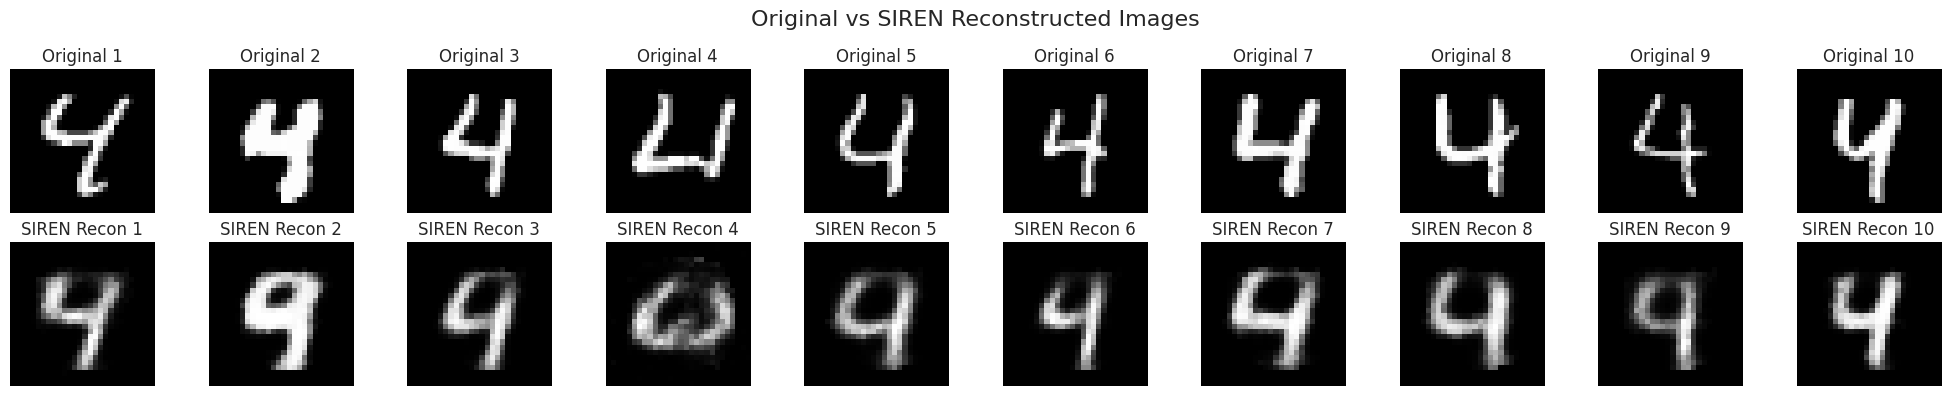

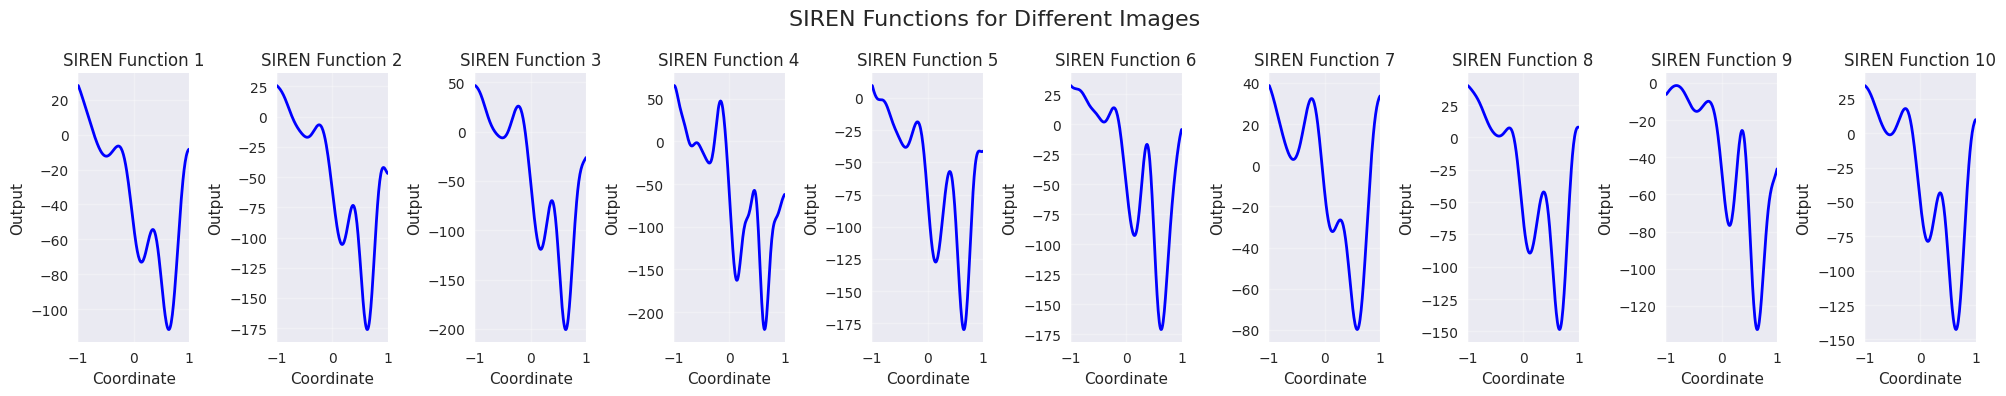

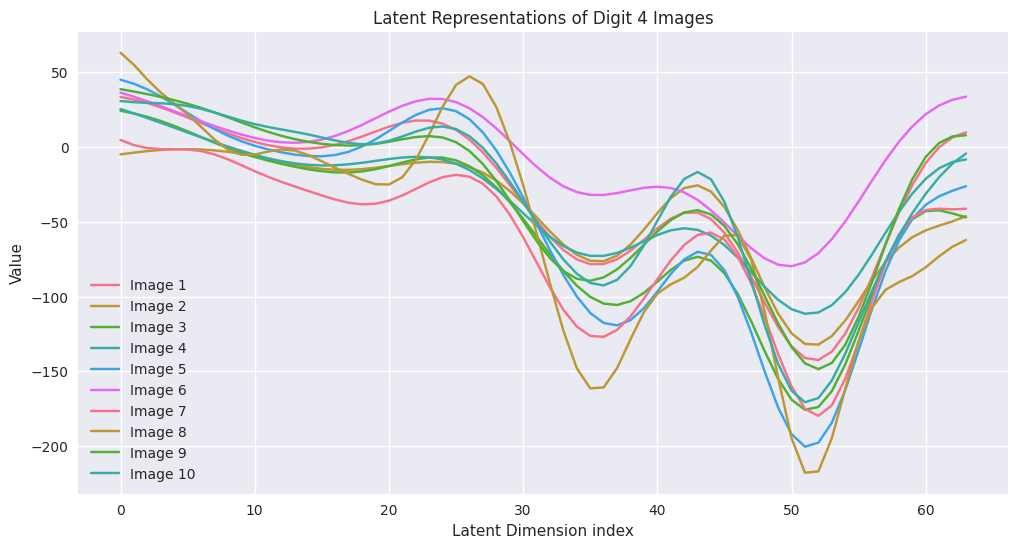


=== SVD Analysis ===
Latent data shape: (10000, 64)
U shape: (10000, 64)
Singular values shape: (64,)
V transpose shape: (64, 64)


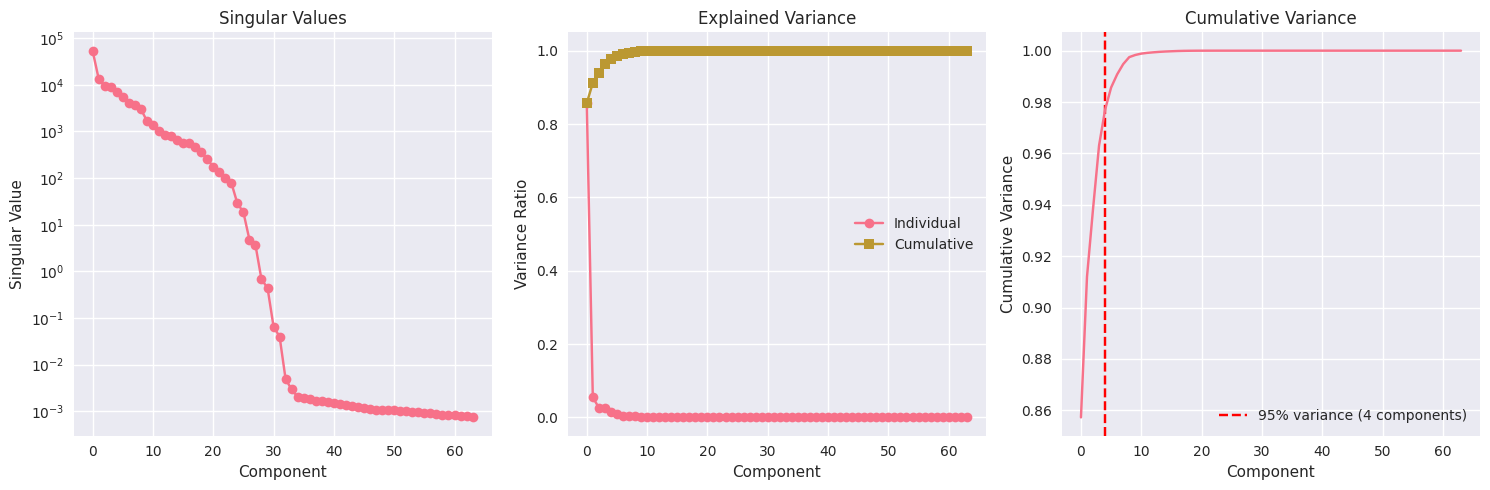


SVD Analysis Results:
Total components: 64
Components for 90% variance: 2
Components for 95% variance: 4
Components for 99% variance: 7
Effective dimensionality: 7.52
Reconstruction error with 10 components: 8.927417
Reconstruction error with 50 components: 0.000000
Reconstruction error with 64 components: 0.000000


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SIRENLayer(nn.Module):
    """Single SIREN layer with sine activation."""
    
    def __init__(self, in_features, out_features, omega_0=5.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        
        with torch.no_grad():
            if self.is_first:
                # First layer - uniform over [-1/n_in, 1/n_in]
                self.linear.weight.uniform_(-1/in_features, 1/in_features)
            else:
                # Hidden layers - uniform over [-sqrt(6/n_in)/omega_0, sqrt(6/n_in)/omega_0]
                bound = np.sqrt(6/in_features) / omega_0
                self.linear.weight.uniform_(-bound, bound)
            
            # All biases are zeros
            self.linear.bias.zero_()
    
    def forward(self, x):
        if self.is_first:
            return torch.sin(self.omega_0 * self.linear(x))
        else:
            return torch.sin(self.omega_0 * self.linear(x))

class SIRENNetwork(nn.Module):
    """SIREN network implementation."""
    
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, omega_0=5.0):
        super().__init__()
        self.omega_0 = omega_0
        
        # First layer
        self.first_layer = SIRENLayer(in_features, hidden_features, omega_0, is_first=True)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            SIRENLayer(hidden_features, hidden_features, omega_0, is_first=False)
            for _ in range(hidden_layers)
        ])
        
        # Final layer (no sine activation)
        self.final_layer = nn.Linear(hidden_features, out_features)
        
        # Initialize final layer
        with torch.no_grad():
            bound = np.sqrt(6/hidden_features) / omega_0
            self.final_layer.weight.uniform_(-bound, bound)
            self.final_layer.bias.zero_()
    
    def forward(self, x):
        x = self.first_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.final_layer(x)
        return x

def get_siren_coordinates(latent_dim, device='cpu'):
    """Generate coordinate inputs for SIREN network."""
    indices = torch.arange(1, latent_dim + 1, dtype=torch.float32, device=device)
    coordinates = 2.0 * indices / latent_dim - 1.0  # Scale to [-1, 1]
    return coordinates.unsqueeze(1)  # Shape: (latent_dim, 1)

class SIRENAutoencoder(nn.Module):
    def __init__(self, latent_dim=64, hidden_dims=[512, 256, 128], 
                 siren_hidden_dims=[64], omega_0=5.0):
        """
        SIREN-based autoencoder for MNIST compression.
        
        Args:
            latent_dim: Dimension of the latent space (output of SIREN)
            hidden_dims: List of hidden layer dimensions for encoder/decoder
            siren_hidden_dims: Hidden dimensions for SIREN network
            omega_0: Frequency parameter for SIREN activations
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.siren_hidden_dims = siren_hidden_dims
        self.omega_0 = omega_0
        
        # Calculate total number of SIREN parameters
        self.siren_param_count = self._count_siren_params()
        
        # Generate coordinate inputs for SIREN (will be moved to device later)
        self.register_buffer('siren_coords', get_siren_coordinates(latent_dim))
        
        self.setup_networks()
        
    def _count_siren_params(self):
        """Count total number of parameters in SIREN network."""
        siren_layers = [1] + self.siren_hidden_dims + [1]
        total_params = 0
        for i in range(len(siren_layers) - 1):
            n_in, n_out = siren_layers[i], siren_layers[i+1]
            total_params += n_in * n_out + n_out  # weights + biases
        return total_params
        
    def setup_networks(self):
        """Initialize encoder and decoder networks."""
        # Build encoder - outputs SIREN parameters
        encoder_layers = []
        input_dim = 28 * 28
        
        for hidden_dim in self.hidden_dims:
            encoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU()
            ])
            input_dim = hidden_dim
        
        # Final layer outputs SIREN parameters
        encoder_layers.append(nn.Linear(input_dim, self.siren_param_count))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder
        decoder_layers = []
        input_dim = self.latent_dim
        
        for hidden_dim in reversed(self.hidden_dims):
            decoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU()
            ])
            input_dim = hidden_dim
        
        # Final layer to reconstruct input
        decoder_layers.extend([
            nn.Linear(input_dim, 28 * 28),
            nn.Sigmoid()
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def _unflatten_siren_params_batch(self, flat_params):
        """Convert flat parameter vectors to SIREN network structure for entire batch."""
        siren_layers = [1] + self.siren_hidden_dims + [1]
        batch_size = flat_params.shape[0]
        params = []
        idx = 0
        
        for i in range(len(siren_layers) - 1):
            n_in, n_out = siren_layers[i], siren_layers[i+1]
            
            # Extract weights for entire batch
            weight_size = n_in * n_out
            weights = flat_params[:, idx:idx + weight_size].view(batch_size, n_in, n_out)
            idx += weight_size
            
            # Extract biases for entire batch
            biases = flat_params[:, idx:idx + n_out].view(batch_size, 1, n_out)
            idx += n_out
            
            params.append((weights, biases))
        
        return params
    
    def siren_forward_batch(self, coords, siren_params_batch):
        """Vectorized forward pass for SIREN network across batch and coordinates."""
        batch_size = siren_params_batch[0][0].shape[0]  # Get batch size from weights
        num_coords = coords.shape[0]
        
        # Expand coordinates to match batch size: (num_coords, 1) -> (batch_size, num_coords, 1)
        x = coords.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, num_coords, 1)
        
        # First layer with sine activation
        weights, biases = siren_params_batch[0]  # weights: (batch_size, 1, hidden), biases: (batch_size, 1, hidden)
        # Batch matrix multiply: (batch_size, num_coords, 1) @ (batch_size, 1, hidden) -> (batch_size, num_coords, hidden)
        x = torch.sin(self.omega_0 * (torch.bmm(x, weights) + biases))
        
        # Hidden layers with sine activation
        for i in range(1, len(siren_params_batch) - 1):
            weights, biases = siren_params_batch[i]
            x = torch.sin(self.omega_0 * (torch.bmm(x, weights) + biases))
        
        # Output layer (no sine activation)
        weights, biases = siren_params_batch[-1]
        output = torch.bmm(x, weights) + biases  # Shape: (batch_size, num_coords, 1)
        
        return output.squeeze(-1)  # Shape: (batch_size, num_coords)
    
    def encode_to_latent(self, images):
        """Encode images to latent space via SIREN network - fully vectorized."""
        # Get SIREN parameters from encoder
        flat_siren_params = self.encoder(images)  # Shape: (batch_size, siren_param_count)
        
        # Unflatten SIREN parameters for entire batch
        siren_params_batch = self._unflatten_siren_params_batch(flat_siren_params)
        
        # Generate latent codes using vectorized SIREN forward pass
        latent_codes = self.siren_forward_batch(self.siren_coords, siren_params_batch)
        
        return latent_codes
    
    def forward(self, images):
        """Forward pass through the entire autoencoder."""
        # Encode to latent space via SIREN
        latent_code = self.encode_to_latent(images)
        # Decode back to image space
        reconstructed = self.decoder(latent_code)
        return reconstructed
    
    def encode_images(self, images):
        """Encode images to latent space."""
        return self.encode_to_latent(images)
    
    def decode_latent(self, latent_codes):
        """Decode latent codes to images."""
        return self.decoder(latent_codes)
    
    def get_compression_ratio(self):
        """Calculate compression ratio."""
        original_size = 28 * 28  # 784 pixels
        compressed_size = self.siren_param_count
        compression_ratio = original_size / compressed_size
        return compression_ratio

class Trainer:
    def __init__(self, model, lr=0.001, momentum=0.9, loss_type='mse'):
        """
        Args:
            loss_type: 'mse' for mean squared error or 'bce' for binary cross-entropy
        """
        self.model = model
        self.loss_type = loss_type
        self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        
        self.history = {
            'train_loss': [],
            'test_loss': []
        }
        
        # Choose loss function
        if loss_type == 'mse':
            self.loss_fn = nn.MSELoss()
        elif loss_type == 'bce':
            self.loss_fn = nn.BCELoss()
        else:
            raise ValueError("loss_type must be 'mse' or 'bce'")
    
    def train_step(self, batch):
        """Single training step."""
        self.model.train()
        self.optimizer.zero_grad()
        
        reconstructed = self.model(batch)
        loss = self.loss_fn(reconstructed, batch)
        
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train_epoch(self, train_loader):
        """Train for one epoch."""
        total_loss = 0.0
        num_batches = 0
        
        for batch_images, _ in train_loader:
            batch_images = batch_images.to(device)
            loss = self.train_step(batch_images)
            total_loss += loss
            num_batches += 1
        
        return total_loss / num_batches
    
    def evaluate(self, test_loader):
        """Evaluate the model."""
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        
        with torch.no_grad():
            for batch_images, _ in test_loader:
                batch_images = batch_images.to(device)
                reconstructed = self.model(batch_images)
                loss = self.loss_fn(reconstructed, batch_images)
                
                total_loss += loss.item() * batch_images.size(0)
                total_samples += batch_images.size(0)
        
        return total_loss / total_samples

class Visualizer:
    def __init__(self, model):
        self.model = model
    
    def plot_training_history(self, history, save_path=None):
        """Plot training history."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        ax.plot(history['train_loss'], 'b-', alpha=0.8, label='Training Loss')
        ax.plot(history['test_loss'], 'r-', alpha=0.8, label='Test Loss')
        ax.set_title('SIREN Autoencoder Training History', fontsize=16)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Reconstruction Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_reconstructions(self, test_loader, num_examples=10, save_path=None):
        """Plot original vs reconstructed images."""
        self.model.eval()
        
        # Get a batch of test images
        test_images, test_labels = next(iter(test_loader))
        test_images = test_images.to(device)
        
        # Select random images
        indices = torch.randperm(test_images.size(0))[:num_examples]
        original_images = test_images[indices]
        
        with torch.no_grad():
            reconstructed = self.model(original_images)
        
        # Move to CPU for plotting
        original_images = original_images.cpu()
        reconstructed = reconstructed.cpu()
        
        fig, axes = plt.subplots(2, num_examples, figsize=(20, 4))
        fig.suptitle('Original vs SIREN Reconstructed Images', fontsize=16)
        
        for i in range(num_examples):
            # Original images
            axes[0, i].imshow(original_images[i].view(28, 28), cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
            axes[1, i].set_title(f'SIREN Recon {i+1}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_siren_functions(self, test_loader, num_examples=5, save_path=None):
        """Visualize SIREN functions for different images."""
        self.model.eval()
        
        # Get a batch of test images
        test_images, _ = next(iter(test_loader))
        test_images = test_images.to(device)
        
        # Select random images
        indices = torch.randperm(test_images.size(0))[:num_examples]
        selected_images = test_images[indices]
        
        # Get SIREN parameters for selected images
        with torch.no_grad():
            flat_siren_params = self.model.encoder(selected_images)
            siren_params_batch = self.model._unflatten_siren_params_batch(flat_siren_params)
        
        # Create fine-grained coordinate inputs for visualization
        coords_fine = torch.linspace(-1, 1, 200, device=device).unsqueeze(1)
        
        # Evaluate SIREN over fine coordinates using vectorized operation
        with torch.no_grad():
            siren_outputs_batch = self.model.siren_forward_batch(coords_fine, siren_params_batch)
        
        fig, axes = plt.subplots(1, num_examples, figsize=(20, 4))
        fig.suptitle('SIREN Functions for Different Images', fontsize=16)
        
        coords_cpu = coords_fine.cpu().numpy().flatten()
        siren_outputs_cpu = siren_outputs_batch.cpu().numpy()
        
        for i in range(num_examples):
            # Plot SIREN function
            axes[i].plot(coords_cpu, siren_outputs_cpu[i], 'b-', linewidth=2)
            axes[i].set_title(f'SIREN Function {i+1}')
            axes[i].set_xlabel('Coordinate')
            axes[i].set_ylabel('Output')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(-1, 1)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def analyze_compression(self, test_loader, num_samples=100):
        """Analyze compression quality and statistics."""
        self.model.eval()
        
        # Collect samples
        sample_images = []
        sample_count = 0
        
        with torch.no_grad():
            for batch_images, _ in test_loader:
                batch_images = batch_images.to(device)
                sample_images.append(batch_images)
                sample_count += batch_images.size(0)
                if sample_count >= num_samples:
                    break
        
        sample_images = torch.cat(sample_images, dim=0)[:num_samples]
        
        # Get reconstructions
        with torch.no_grad():
            reconstructed = self.model(sample_images)
        
        # Calculate metrics
        mse_per_image = torch.mean((sample_images - reconstructed) ** 2, dim=1)
        mean_mse = torch.mean(mse_per_image).item()
        std_mse = torch.std(mse_per_image).item()
        
        # Calculate PSNR
        psnr_per_image = 20 * torch.log10(1.0 / torch.sqrt(mse_per_image))
        mean_psnr = torch.mean(psnr_per_image).item()
        
        compression_ratio = self.model.get_compression_ratio()
        
        print("=" * 50)
        print("SIREN AUTOENCODER COMPRESSION ANALYSIS")
        print("=" * 50)
        print(f"Latent Dimension: {self.model.latent_dim}")
        print(f"SIREN Parameters: {self.model.siren_param_count}")
        print(f"SIREN Hidden Dims: {self.model.siren_hidden_dims}")
        print(f"Omega_0: {self.model.omega_0}")
        print(f"Compression Ratio: {compression_ratio:.2f}:1")
        print(f"Original Size: {28*28} pixels")
        print(f"Compressed Size: {self.model.siren_param_count} SIREN params")
        print(f"Mean MSE: {mean_mse:.6f} ± {std_mse:.6f}")
        print(f"Mean PSNR: {mean_psnr:.2f} dB")
        print("=" * 50)

def load_mnist_data(batch_size=64):
    """Load MNIST data using PyTorch DataLoader."""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to [0, 1] and changes to (C, H, W)
        transforms.Lambda(lambda x: x.view(-1))  # Flatten to vector
    ])
    
    # Load datasets
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")
    
    return train_loader, test_loader

# Main training script
if __name__ == "__main__":
    # Hyperparameters
    lr = 0.001
    num_epochs = 500
    batch_size = 64
    latent_dim = 64  # Output dimension of SIREN
    hidden_dims = [512, 256, 128]  # Encoder/decoder architecture
    siren_hidden_dims = [128]  # SIREN network architecture
    omega_0 = 5.0  # SIREN frequency parameter
    loss_type = 'mse'  # 'mse' or 'bce'
    
    # Initialize model and trainer
    model = SIRENAutoencoder(
        latent_dim=latent_dim, 
        hidden_dims=hidden_dims,
        siren_hidden_dims=siren_hidden_dims,
        omega_0=omega_0
    ).to(device)
    
    trainer = Trainer(model, lr=lr, loss_type=loss_type)
    visualizer = Visualizer(model)
    
    print(f"SIREN compression ratio: {model.get_compression_ratio():.2f}:1")
    print(f"SIREN parameter count: {model.siren_param_count}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Load data
    print("Loading MNIST data...")
    train_loader, test_loader = load_mnist_data(batch_size)
    
    # Training loop
    print("Starting SIREN autoencoder training...")
    for epoch in range(num_epochs):
        tic = time.time()
        
        # Train
        train_loss = trainer.train_epoch(train_loader)
        
        # Evaluate
        test_loss = trainer.evaluate(test_loader)
        
        # Store history
        trainer.history['train_loss'].append(train_loss)
        trainer.history['test_loss'].append(test_loss)
        
        # Print progress
        elapsed = time.time() - tic
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | "
              f"Test Loss: {test_loss:.6f} | Time: {elapsed:.2f}s")
    
    # Final visualizations and analysis
    print("\nTraining completed! Generating visualizations...")
    
    # Plot training history
    visualizer.plot_training_history(trainer.history)
    
    # Plot reconstructions
    visualizer.plot_reconstructions(test_loader, num_examples=10)
    
    # Plot SIREN functions
    visualizer.plot_siren_functions(test_loader, num_examples=10)
    
    # Analyze compression performance
    visualizer.analyze_compression(test_loader, num_samples=1000)
    
    print("All visualizations complete!")
    
    # Additional analysis sections (similar to original)
    
    # Analysis for digit 4
    print("\n=== Analysis for digit 4 ===")
    
    # Filter test data for digit 4
    digit_4_data = []
    digit_4_labels = []
    
    for batch_images, batch_labels in test_loader:
        mask = batch_labels == 4
        if mask.any():
            digit_4_data.append(batch_images[mask])
            digit_4_labels.append(batch_labels[mask])
    
    if digit_4_data:
        digit_4_images = torch.cat(digit_4_data, dim=0)[:10]  # Take first 10
        digit_4_dataset = TensorDataset(digit_4_images, torch.zeros(len(digit_4_images)))
        digit_4_loader = DataLoader(digit_4_dataset, batch_size=10, shuffle=False)
        
        # Plot reconstructions for digit 4
        visualizer.plot_reconstructions(digit_4_loader, num_examples=10)
        
        # Plot SIREN functions for digit 4
        visualizer.plot_siren_functions(digit_4_loader, num_examples=10)
        
        # Plot latent representations for digit 4
        model.eval()
        with torch.no_grad():
            digit_4_images = digit_4_images.to(device)
            latent_codes = model.encode_images(digit_4_images)
            latent_codes = latent_codes.cpu().numpy()
        
        plt.figure(figsize=(12, 6))
        for i in range(min(10, len(latent_codes))):
            plt.plot(np.arange(latent_dim), latent_codes[i], label=f'Image {i+1}')
        plt.title('Latent Representations of Digit 4 Images')
        plt.xlabel('Latent Dimension index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    
    # SVD Analysis
    print("\n=== SVD Analysis ===")
    
    # Collect all test latent representations
    model.eval()
    all_latent_codes = []
    
    with torch.no_grad():
        for batch_images, _ in test_loader:
            batch_images = batch_images.to(device)
            latent_codes = model.encode_images(batch_images)
            all_latent_codes.append(latent_codes.cpu())
    
    all_latent_codes = torch.cat(all_latent_codes, dim=0).numpy()
    print(f"Latent data shape: {all_latent_codes.shape}")
    
    # Perform SVD
    U, s, Vt = np.linalg.svd(all_latent_codes, full_matrices=False)
    
    print(f"U shape: {U.shape}")
    print(f"Singular values shape: {s.shape}")
    print(f"V transpose shape: {Vt.shape}")
    
    # Analyze the singular values
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Singular values
    plt.subplot(1, 3, 1)
    plt.plot(s, 'o-')
    plt.title('Singular Values')
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    plt.yscale('log')
    
    # Plot 2: Explained variance ratio
    variance_explained = (s**2) / np.sum(s**2)
    cumulative_variance = np.cumsum(variance_explained)
    
    plt.subplot(1, 3, 2)
    plt.plot(variance_explained, 'o-', label='Individual')
    plt.plot(cumulative_variance, 's-', label='Cumulative')
    plt.title('Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Variance Ratio')
    plt.legend()
    
    # Plot 3: Effective dimensionality
    plt.subplot(1, 3, 3)
    # Find components that explain 95% of variance
    n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
    plt.axvline(n_components_95, color='red', linestyle='--', 
               label=f'95% variance ({n_components_95} components)')
    plt.plot(cumulative_variance)
    plt.title('Cumulative Variance')
    plt.xlabel('Component')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    print(f"\nSVD Analysis Results:")
    print(f"Total components: {len(s)}")
    print(f"Components for 90% variance: {np.where(cumulative_variance >= 0.90)[0][0] + 1}")
    print(f"Components for 95% variance: {n_components_95}")
    print(f"Components for 99% variance: {np.where(cumulative_variance >= 0.99)[0][0] + 1}")
    
    # Effective dimensionality (using entropy-based measure)
    normalized_s = s / np.sum(s)
    effective_dim = np.exp(-np.sum(normalized_s * np.log(normalized_s + 1e-12)))
    print(f"Effective dimensionality: {effective_dim:.2f}")
    
    # Reconstruction with different numbers of components
    def reconstruct_with_k_components(k):
        """Reconstruct data using only first k components"""
        return U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    
    k_values = [10, 50, 100, min(200, len(s))]
    reconstruction_errors = []
    
    for k in k_values:
        if k <= len(s):
            reconstructed = reconstruct_with_k_components(k)
            error = np.mean((all_latent_codes - reconstructed)**2)
            reconstruction_errors.append(error)
            print(f"Reconstruction error with {k} components: {error:.6f}")